In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm
import arviz as az
import pymc3 as pm
import seaborn as sns
from scipy.stats import norm
import numpy as np
import scipy.stats as stats

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Assignment 1: Toxicity bioassay

## Problem and data

A **bioassay** is biochemical test to estimate the potency of a sample compound. A typical bioassay involves a stimulus (ex. drugs) applied to a subject (ex. animals, tissues, plants). The corresponding response (ex. death) of the subject is thereby triggered and measured (Wikipedia).

The following bioassay taken from Racine et al. (1986) is meant to evaluate the toxicity of a drug on animals. The effect of the drug is evaluated at $N=4$ dose levels. Each dose level $x_i$ is administered to a batch of $n_i$ animals. The number of deaths $y_i$ is the observed response.

| |Dose $x_i$ (log g/ml) | Number of animals $n_i$ | Number of deaths $y_i$ |
| ---|--- | --- | --- |
| 1|-0.86 | 5 | 0 |
| 2|-0.30 | 5 | 1 |
| 3|-0.05 | 5 | 3 |
| 4|0.73  | 5 | 5 |


For instance, the dose level $x_3=-0.05$ has been administered at $n_3=5$ animals. Out of the 5 animals, $y_3=3$ died. <br/>
Note that the dose $x_i$ is measured on a logarithmic scale. Thus, negative concentration levels are present.

We define for convenience (both as math symbols and as Python objects) the vectors $x$, $n$, and $y$ containing the quantities of the corresponding columns.

In [2]:
x = np.array([-0.86, -0.30, -0.05, 0.73]) # dose levels
n = np.array([5., 5., 5., 5.]) # number of subjects per dose level
y = np.array([0, 1, 3, 5]) # number of deaths per dose level

## Modeling assumptions

For the probabilistic model, we make the following assumptions:

1. The outcome of the $n_i$ animals within each group $i$ are *independent*. Each animal in the group has probability $p_i$ of death.

2. The probability of death $p_i$ depends on the dose $x_i$ as follows:
    $$p_i = \rm{sigm}(\alpha + \beta x_i),$$ 
    where 
    \begin{align*}
    \rm{sigm}(z) = \frac{1}{1 + e^{-z}}.
    \end{align*}
3. The prior probability of the parameters 
$\theta = \begin{bmatrix}
\alpha \\
\beta
\end{bmatrix}$
is Gaussian: 
\begin{align}
\alpha &\sim \mathcal{N}(\mu_\alpha, \sigma^2_\alpha), \qquad \mu_\alpha = 0, \sigma_\alpha=2\\
\beta &\sim \mathcal{N}(\mu_\beta, \sigma^2_\beta), \qquad \mu_\beta=10, \sigma_\beta=10.
\end{align}
4. The outcomes in the four groups are independent of each other, given $\theta$.


## 1.1: Probabilistic model

* Derive and comment the full probabilistic model.

The full probabilistic model is:

\begin{align}
\alpha &\sim \mathcal{N}(\mu_\alpha, \sigma^2_\alpha), \qquad \mu_\alpha = 0, \sigma_\alpha=2\\
\beta &\sim \mathcal{N}(\mu_\beta, \sigma^2_\beta), \qquad \mu_\beta=10, \sigma_\beta=10,
\end{align}
\begin{align}
\\y|\alpha, \beta, x \sim \rm{Bin}(n, sigm(a + b*x)).
\end{align}

The random variable $y$ represents the number of success (deaths) events over $n$ trials.

## 1.2: Maximum Likelihood estimation 

* Derive an analytical expression of the likelihood function $\mathcal{L}(\theta) = P(y|\theta)$.

$$\mathcal{L}(\theta) = P(y|\theta) = {{n}\choose{y}} \theta^{y} \cdot (1-\theta)^{n-y},$$
as a function of $\theta$, with $y$ fixed to the observed value. 

* Write a Python function corresponding to the likelihood function $\mathcal{L}(\theta)$. Ignore multiplicative factors which do not depend on $\theta$.

In [3]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def likelihood(params):
    alpha, beta = params
    lik = 1
    for i in range(len(x)):
        lik *= sigmoid(alpha+(beta*x[i]))**y[i] * (1 - sigmoid(alpha+(beta*x[i])))**(n[i] - y[i])
    return lik

* Visualize the likelihood function in 2D and comment the obtained figure. 

   Hints:
    * you may use the `pcolormesh` function of `matplotlib`
    * appropriate ranges for $\alpha$ and $\beta$ are $[-4, 8]$ and $[-10, 40]$, respectively
    * an appropriate step size for both $\alpha$ and $\beta$ is 0.01

In [4]:
with pm.Model() as model_height:

    # prior distributions
    alpha = pm.Normal('alpha', 0, 2)
    beta = pm.Normal('beta', 10, 10)
    
    p = pm.Binomial('y', n=n, p=sigmoid(alpha + beta * x), observed=y)
    
    trace_height = pm.sample(return_inferencedata=True) # defaults: 1000, 1000

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


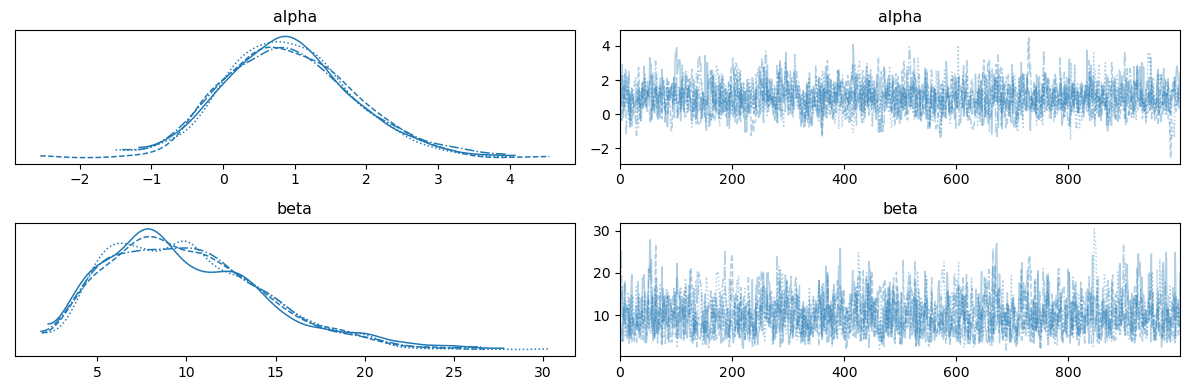

In [5]:
with model_height:
    az.plot_trace(trace_height)
    plt.tight_layout()

In [6]:
alpha_vec = np.arange(-4, 4, 0.1)
beta_vec = np.arange(-10, 30, 0.1)
lik_matrix = np.zeros((len(alpha_vec), len(beta_vec))) 

for alpha_idx, alpha_val in enumerate(alpha_vec):
    for beta_idx, beta_val in enumerate(beta_vec):
        lik_matrix[alpha_idx, beta_idx] = likelihood((alpha_val, beta_val))

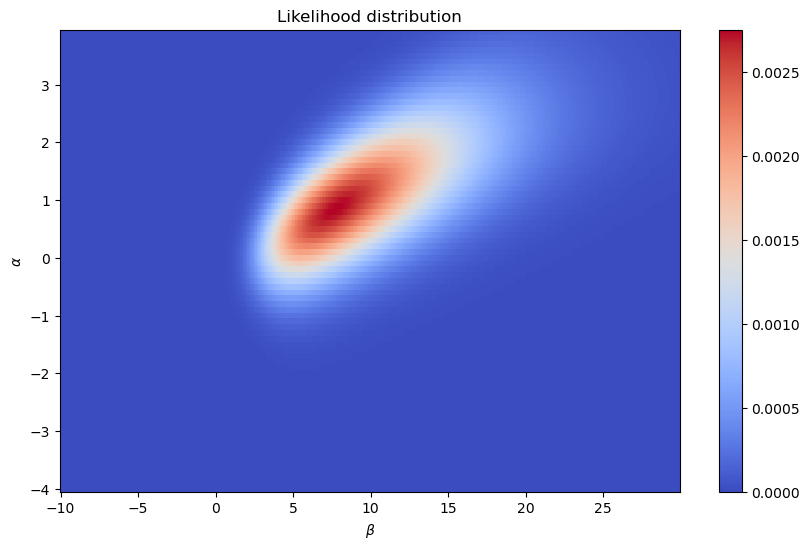

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(beta_vec, alpha_vec, lik_matrix, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood distribution")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\alpha$");

* Derive an analytical expression of the log-likelihood function $\ell(\theta)$. 

We start from the definition of the posterior function:

$$f_{\rm post}(\theta) = f(\theta | y) = \frac{{P(y|\theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$$

we obtain the following formula for the log-posterior $g(\theta)$:
$$ g(\theta) = \log f_{\rm post}(\theta) = \overbrace{\log P(y|\theta)}^{=\ell(\theta)} + \log f_{\rm prior}(\theta) + \log P(y)$$

With this, we can compute the log-likelihood $\ell(\theta)$:
$$\ell(\theta) = \log \mathcal{L}(\theta) = \log P(y|\theta) = \log{{N}\choose{k}} + y \log \theta + (n-y) \log (1-\theta)$$

* Write a Python function corresponding to the log-likelihood function $\ell(\theta)$, possibly up to an additive factor not depending on $\theta$. 

* Visualize the log-likelihood function in 2D and comment the obtained figure. 

In [8]:
def log_likelihood(params):
    alpha, beta = params
    loglik = 0
    for i in range(len(x)):
        loglik += np.log(sigmoid(alpha+(beta*x[i]))) + (y[i] * np.log(sigmoid(alpha+(beta*x[i])))) + (n[i] - y[i]) * np.log(1 - sigmoid(alpha+(beta*x[i])))
    return -loglik

In [9]:
# changed to 4, 30 for the max values as otherwise it would result in nan values from the log likelihood.
# now the values range from +-2sd from mean.
log_mat = np.zeros((len(alpha_vec), len(beta_vec))) 

dalpha = np.diff(alpha_vec)[0]
dbeta = np.diff(beta_vec)[0]

for alpha_idx, alpha_val in enumerate(alpha_vec):
    for beta_idx, beta_val in enumerate(beta_vec):
        log_mat[alpha_idx, beta_idx] = -log_likelihood((alpha_val, beta_val)) # inverting the sign so that it displays correctly

# from log pdf to pdf, robust way
max_log = np.max(log_mat)
log_mat = log_mat - max_log # shift the logpdf to have a maximum of 0 <- this makes the plot all white
mat = np.exp(log_mat) # exponentiate safely (maximum value is exp(0)=1)

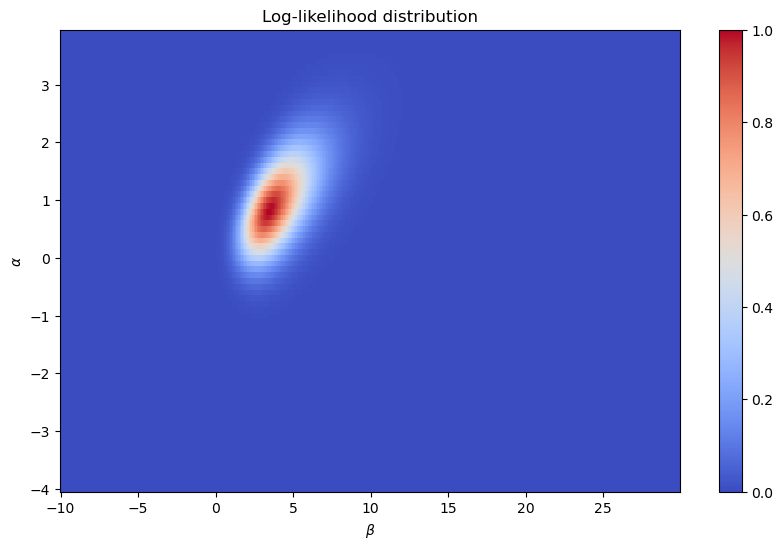

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(beta_vec, alpha_vec, mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Log-likelihood distribution")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\alpha$");

* Compute the maximum likelihood estimate $\alpha^{\rm ml}, \beta^{\rm ml}$ of the parameters $\alpha, \beta$ through numerical optimizations. 

    Hints:
     * You may use the Python function `scipy.optimize.minimize`. 
     * You may look at the figures above to define a good starting point for optimization 
     * You may either minimize the likelihood or the log-likelihood. What is your choice?

In [11]:
from scipy.optimize import minimize

# Initialize the parameters
alpha = 4
beta = 30
params = (alpha, beta)

# Use the minimize function to find the MLE
result = minimize(log_likelihood, params)

# Print the MLE
alpha_mle, beta_mle = result.x
print(f'Alpha MLE: {alpha_mle:.3f}')
print(f'Beta MLE: {beta_mle:.3f}')

Alpha MLE: 0.820
Beta MLE: 3.497


The log likelihood function is defined as the sum of the logarithm of the probability density function (PDF) for each data point, given the parameters 𝛼 and 𝛽. The log likelihood function has the same maximum value as the likelihood function, and it is often easier to work with because it is a sum rather than a product. By minimizing the negative of the log likelihood function, we are effectively maximizing the log likelihood function, which is equivalent to maximizing the likelihood function.

* Visualize the likelihood function in 2D together with the ML estimate. Comment the obtained figure. 

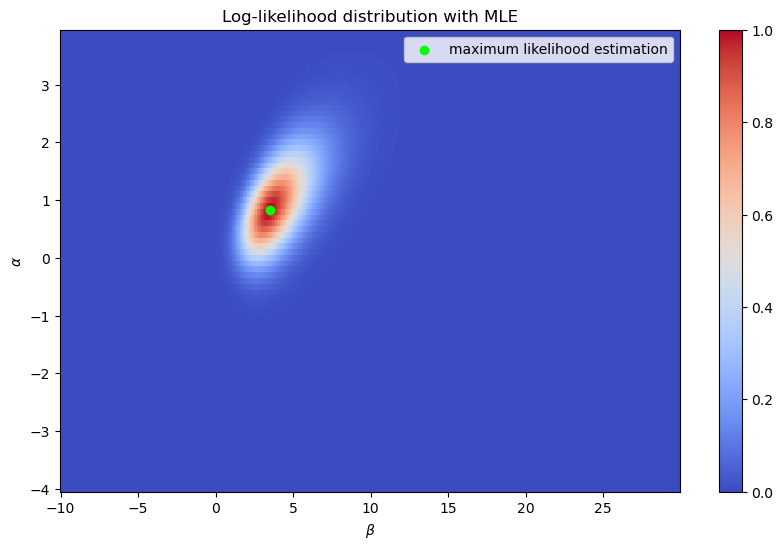

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(beta_vec, alpha_vec, mat, cmap=cm.coolwarm, shading='auto')
ax.scatter(beta_mle, alpha_mle, c='lime', label='maximum likelihood estimation')
fig.colorbar(c, ax=ax)
ax.set_title(f"Log-likelihood distribution with MLE")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\alpha$")
ax.legend()
plt.show()

## 1.3: Maximum A Posteriori estimation

* Derive an analytical expression of the posterior $f(\theta | y)$, up to a multiplicative factor not depending on $\theta$. 

Hint: exploit the already-obtained likelihood and the known functional form of the Gaussian pdf.

the analytical expression of the posterior $f(\theta|y)$ is given by Bayes' theorem:

$$f(\theta | y) = \frac{{P(y|\theta)} \cdot P(\theta)}{P(y)},$$
where $P(y|\theta)$ is the likelihood function, $P(\theta)$ is the prior distribution, and $P(y)$ is the marginal likelihood or evidence.

* Derive an analytical expression of the log-posterior $\log f(\theta | y)$, up to an additive factor not depending on $\theta$.

The log-posterior $log f(\theta|y)$ is given by the logarithm of the posterior $f(\theta|y)$, which is given by Bayes' theorem:

$log f(\theta|y)$ = $log P(y|\theta)$ + $log P(\theta)$ - $log P(y)$

where $log P(y|\theta)$, $log P(\theta)$, and $log P(y)$ are the logarithms of the likelihood function, prior distribution, and marginal likelihood or evidence, respectively.

Given the data and the model, the likelihood function $log P(y|\theta)$ is:

$$log P(y|\theta) = \prod(p_{\rm i})^{(n_{\rm i}y_{\rm i})}(1-p_{\rm i})^{(n_{\rm i}(1-y_{\rm i}))}$$

where $n_{\rm i}$ is the number of subjects in group $i$ , $p_{\rm i}$ is the number of deaths in group $i$ , $$p_{\rm i} = sigmoid(\alpha+\beta x_{\rm i})$$ with $$sigmoid(z)=\frac{1}{(1+e^{(-z)})}$$ is the probability of death for group $i$.

Taking the logarithm of this likelihood function and applying the log-sum-exp trick, we have:

$$log P(y|\theta) = \sum n_{\rm i}(y_{\rm i} log p_{\rm i} +(1−y_{\rm i})log(1−p_{\rm i}))$$


The final analytical expression of the log-posterior $log f(\theta|y)$ up to an additive factor not depending on $\theta$ is given by:
$$log f(\theta|y) = \sum n_{\rm i}(y_{\rm i} log p_{\rm i} + (1−y_{\rm i})log(1−p_{\rm i})) - \frac{(\alpha-\mu_{\rm \alpha})^2}{2*\sigma_{\rm \alpha}^2} - \frac{(\beta-\mu_{\rm \beta})^2}{2*\sigma_{\rm \beta}^2}$$


The terms $\frac{(\alpha-\mu_{\rm \alpha})^2}{2*\sigma_{\rm \alpha}^2}$ and $\frac{(\beta-\mu_{\rm \beta})^2}{2*\sigma_{\rm \beta}^2}$ in the final analytical expression of the log-posterior $log f(\theta|y)$ represent the logarithm of the prior distributions for alpha and beta. These terms are subtracted from the log-likelihood in order to account for the prior information in the estimation of the parameters $\alpha$ and $\beta$.

The logarithm of the normal distribution is given by:
$$log \mathcal{N}(\theta|\mu,\sigma) = -\frac{1}{2} * log(2\pi\sigma^2) - \frac{(\theta-\mu)^2}{(2*\sigma^2)}$$

The first term is independent of the parameters $\theta$ and it can be ignored when maximizing the log-posterior.

The second term is the negative of the squared difference between the parameter $\theta$ and the mean of the prior distribution ($0$ for $\alpha$ and $10$ for $\beta$) and it is divided by twice the variance of the prior distribution ($2^2$ for $\alpha$ and $10^2$ for $\beta$)

The effect of these terms is that they will have a high value when the current estimate of the parameters is far from the prior mean and low when the current estimate of the parameters is close to the prior mean.

When the optimization algorithm is maximizing the log-posterior, it will be trying to maximize the likelihood while keeping the parameter values close to the prior means and with a low variance, in this way the algorithm is incorporating the prior information into the estimation process.





* Write the unnormalized posterior and log-posterior (up to a multiplicative/additive factor, respectively) as Python functions.

The unnormalized posterior is the product of the likelihood and the prior, where the likelihood is the probability of observing the data given the parameters, and the prior is the probability of the parameters before observing the data.

In [13]:
# Define the prior probability
prior_a = norm(0, 2)
prior_b = norm(10, 10)

def prior(theta):
    a, b = theta
    return prior_a.pdf(a) * prior_b.pdf(b)

# Define the unnormalized posterior probability
def unnorm_posterior(theta):
    return likelihood(theta) * prior(theta)

# Define the negative unnormalized posterior probability (to minimize)
def neg_unnorm_posterior(theta):
    return -unnorm_posterior(theta)

# Define the negative log posterior probability (to minimize)
def log_posterior(theta):
    return np.log(posterior(theta))

# Initial guess for theta
theta_0 = [0, 10]

# Find the MAP estimate using optimization
result = minimize(neg_unnorm_posterior, theta_0)

# Print the MAP estimate
# Get the MAP estimates
alpha_map, beta_map = result.x
print("alpha_map:", alpha_map)
print("beta_map:", beta_map)

alpha_map: 1.0584561730551627
beta_map: 9.841469952223406


* Compute the maximum a posteriore estimate $\alpha^{\rm MAP}, \beta^{\rm MAP}$.

* Visualize the MAP estimate together with the unnormalized posterior in 2D. Comment the results.

In [14]:
post_mat = np.zeros((len(alpha_vec), len(beta_vec))) 

for alpha_idx, alpha_val in enumerate(alpha_vec):
    for beta_idx, beta_val in enumerate(beta_vec):
        post_mat[alpha_idx, beta_idx] = -neg_unnorm_posterior((alpha_val, beta_val))

max_post = np.max(post_mat)
post_mat = post_mat - max_post
posterior = np.exp(post_mat)

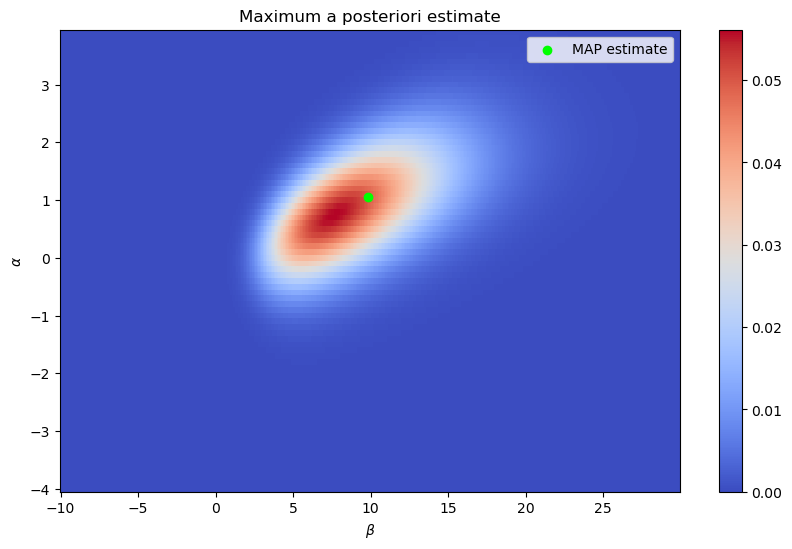

In [26]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 6))
c = ax1.pcolormesh(beta_vec, alpha_vec, posterior, cmap=cm.coolwarm, shading='auto')
plt.scatter(beta_map, alpha_map, color='lime', marker='o', label='MAP estimate')
fig.colorbar(c, ax=ax1)
ax1.set_title(f"Maximum a posteriori estimate")
ax1.set_xlabel(r"$\beta$")
ax1.set_ylabel(r"$\alpha$")
plt.legend()

The estimate is not really precise, but still it seems reasonable.

## 1.4 Brute-force posterior estimation

* Compute a gridding approximation of the *normalized* posterior, with the correct normalization constant. Explain the passages.

We have:
$$f_{\rm post}(\theta) = \frac{1}{Z} \cdot \mathcal{L}(\theta) f_{\rm prior}(\theta),$$

where the normalization constant $Z$ must be chosen to satisfy:

$$\int_\theta f_{\rm post}(\theta) \; d\theta = 1,$$
thus

$$Z = \int_\theta \mathcal{L}(\theta) f_{\rm prior}(\theta) \; d\theta = 1.$$

Any numerical integration method can be used to approximate the integral above. Easiest choice: Riemann sum on a uniform grid, with step size $\Delta \theta$
$$ Z \approx \Delta \theta \sum_{i} \mathcal{L}(\theta_i) f_{\rm prior}(\theta_i)$$

In [16]:
# use the previously defined alpha and beta vectors
# Define the mean and standard deviation for alpha and beta
mu_alpha = 0
sigma_alpha = 2
mu_beta = 10
sigma_beta = 10

# Compute the prior PDFs for alpha and beta
prior_alpha = norm.pdf(alpha_vec, mu_alpha, sigma_alpha)
prior_beta = norm.pdf(beta_vec, mu_beta, sigma_beta)

In [17]:
# Compute the normalization constant
Z = 0
dalpha = abs(alpha_vec[0] - alpha_vec[1]) # 0.1
dbeta = abs(beta_vec[0] - beta_vec[1]) # 0.1
for i in range(len(alpha_vec)):
    for j in range(len(beta_vec)):
        # riemann's approximation
        Z += likelihood((alpha_vec[i], beta_vec[j])) * prior_alpha[i] * prior_beta[j] * dalpha * dbeta

# Compute the posterior PDF
posterior = np.zeros((len(alpha_vec), len(beta_vec)))
for i in range(len(alpha_vec)):
    for j in range(len(beta_vec)):
        posterior[i, j] = likelihood((alpha_vec[i], beta_vec[j])) * prior_alpha[i] * prior_beta[j] / Z

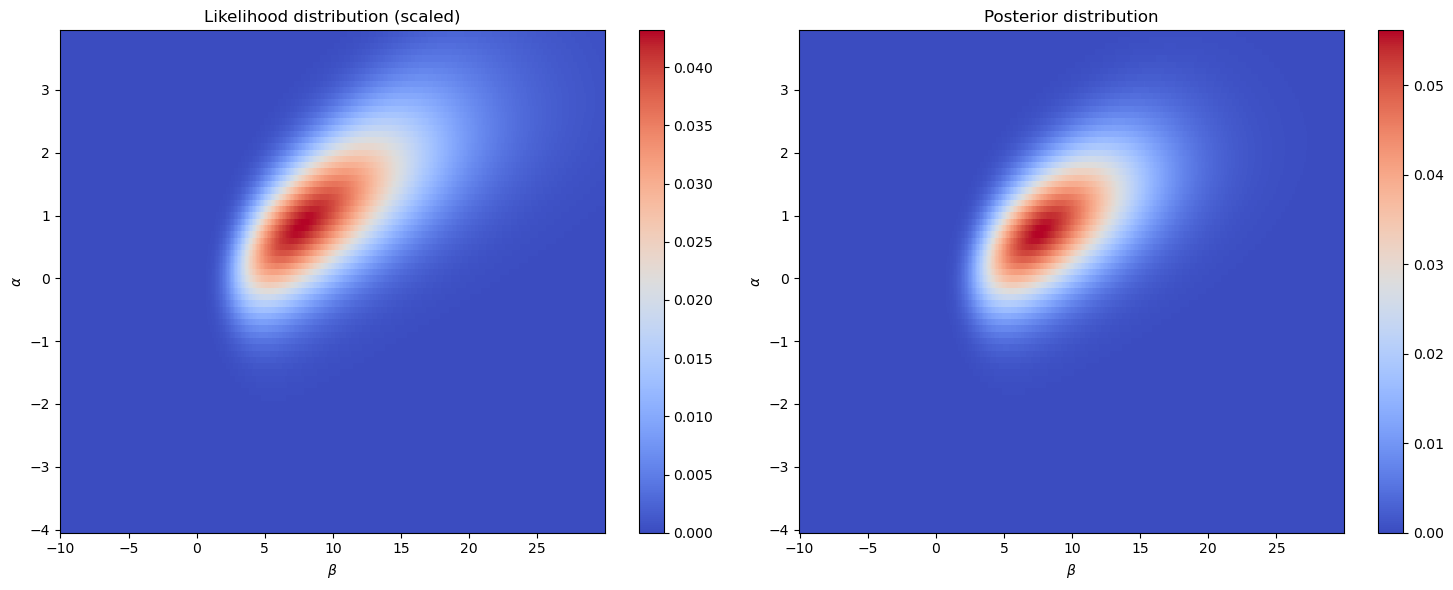

In [18]:
lik_matrix_scaled = lik_matrix/((np.sum(lik_matrix) * dalpha * dbeta))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
c = ax1.pcolormesh(beta_vec, alpha_vec, lik_matrix_scaled, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax1)
ax1.set_title(f"Likelihood distribution (scaled)")
ax1.set_xlabel(r"$\beta$")
ax1.set_ylabel(r"$\alpha$");

c = ax2.pcolormesh(beta_vec, alpha_vec, posterior, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax2)
ax2.set_title(f"Posterior distribution")
ax2.set_xlabel(r"$\beta$")
ax2.set_ylabel(r"$\alpha$")
plt.tight_layout()

* Using the grid-based approximation of the posterior, compute the posterior mean of $\alpha$ and $\beta$.

In [19]:
# Compute the posterior mean of alpha and beta
mean_alpha = np.sum(alpha_vec * posterior.sum(axis=1)) / posterior.sum()
mean_beta = np.sum(beta_vec * posterior.sum(axis=0)) / posterior.sum()

print(f'posterior alpha mean: {mean_alpha:.3f}')
print(f'posterior beta mean: {mean_beta:.3f}')

posterior alpha mean: 0.946
posterior beta mean: 9.967


To calculate the mean value of a variable, we can sum the values of the variable and divide by the number of values. This is known as the arithmetic mean.

In the case of the posterior mean of $\alpha$ and $\beta$, we are using the grid-based approximation of the posterior PDF to estimate the distribution of $\alpha$ and $\beta$. The posterior PDF is a 2D array with dimensions len(alpha) x len(beta), where each element represents the probability of $\alpha$ and $\beta$ taking on a particular combination of values.

To compute the posterior mean of $\alpha$ and $\beta$, we multiply the values of $\alpha$ and $\beta$ by the corresponding elements in the posterior PDF and sum the results. This gives us the weighted sum of $\alpha$ and $\beta$, with the weights being the probabilities from the posterior PDF. Dividing the weighted sum by the sum of the probabilities (which is equal to 1) gives us the posterior mean of $\alpha$ and $\beta$.

## 1.5 Monte-carlo posterior estimation

* Obtain a sample-based approximation of the posterior $f(\theta | y)$ by implementing the Metropolis algorithm from scratch.

In [20]:
# likelihood function
def binom_likelihood(theta):
    alpha, beta = theta
    p = sigmoid(alpha + beta * x)
    return stats.binom.pmf(y, n, p).prod()

# prior distribution
alpha_mean, alpha_std = 0, 2
beta_mean, beta_std = 10, 10

def prior(theta):
    alpha, beta = theta
    return stats.norm.pdf(alpha, alpha_mean, alpha_std) * stats.norm.pdf(beta, beta_mean, beta_std)


# proposal distribution
current_theta = [0, 10] # initial values for alpha and beta
proposal_mean = [0, 10] # mean for proposal distribution
proposal_std = [2, 10] # std for proposal distribution


# initialize algorithm
num_iterations = 50000
samples = []

for i in range(num_iterations):
    # generate candidate value
    candidate_theta = np.random.normal(proposal_mean, proposal_std)

    # calculate acceptance probability
    current_likelihood = binom_likelihood(current_theta)
    candidate_likelihood = binom_likelihood(candidate_theta)
    acceptance_prob = candidate_likelihood * prior(candidate_theta) / (current_likelihood * prior(current_theta))


    # accept or reject candidate
    if acceptance_prob >= np.random.uniform(0, 1):
        current_theta = candidate_theta

        samples.append(current_theta)
        
samples = np.asarray(samples)

* Compare the Metropolis samples with the gridding-based approximation of the posterior distribution $f(\theta | y)$ and comment the result

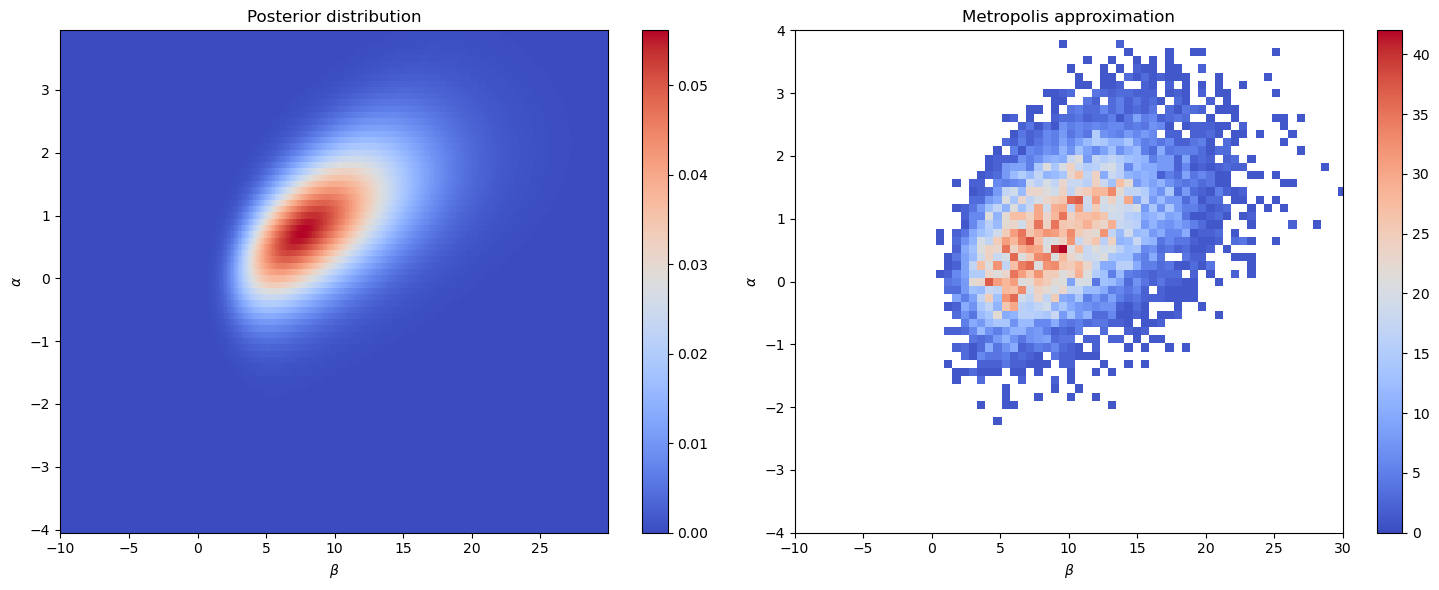

In [21]:
# convert samples to a 2D array with alpha and beta as columns
samples_2d = np.array(samples).T

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

g = sns.histplot(x=samples_2d[1], y=samples_2d[0], bins=50, cmap=cm.coolwarm, ax=ax2, cbar=True)
g.set_title("Metropolis approximation")
g.set_xlabel(r"$\beta$")
g.set_ylabel(r"$\alpha$")
g.set_xlim([-10, 30])
g.set_ylim([-4, 4])

c = ax.pcolormesh(beta_vec, alpha_vec, posterior, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Posterior distribution")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\alpha$")
plt.tight_layout()

* Obtain a sample-based approximation of the posterior $f(\theta | y)$ using pymc3.

In [22]:
# model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    beta = pm.Normal('beta', mu=10, sigma=10)
    p = pm.Deterministic('p', sigmoid(alpha + beta * x))
    deaths = pm.Binomial('deaths', n=n, p=p, observed=y)

    # obtain samples
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


* Comment the results obtained with pymc3 and compare them with previous results (gridding and Metropolis from scratch).

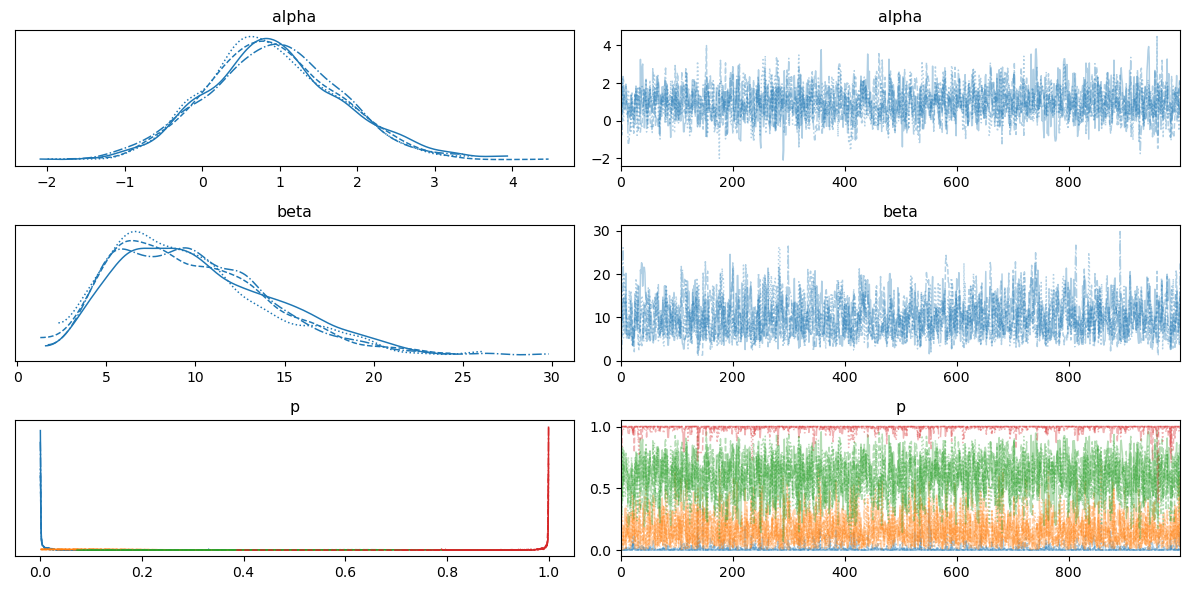

In [23]:
with model:
    az.plot_trace(trace)
    plt.tight_layout()

In [24]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.915,0.855,-0.685,2.526,0.022,0.015,1577.0,1751.0,1.0
beta,9.797,4.299,2.884,17.771,0.120,0.085,1279.0,1647.0,1.0
p[0],0.009,0.026,0.000,0.036,0.001,0.001,1496.0,1715.0,1.0
p[1],0.158,0.119,0.001,0.376,0.002,0.002,2496.0,1975.0,1.0
p[2],0.592,0.163,0.299,0.888,0.004,0.003,2001.0,2009.0,1.0
p[3],0.991,0.029,0.957,1.000,0.001,0.001,1184.0,1358.0,1.0


The results obtained using PyMC3 are likely to be more accurate and robust than the results obtained using the gridding and Metropolis algorithms implemented from scratch. In fact, we see a r_hat close or equal to 1, meaning the model is converging.

Still, when we look at the colormesh plot, we see that the metropolis algorithm performs quite good.